# Imports

In [212]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn import metrics

from sklearn import preprocessing as pp
from sklearn import model_selection   as ms
from sklearn import ensemble          as en

import scikitplot as skplt

# Load Data

## Helper Functions

In [8]:
df_raw = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [88]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

In [9]:
df_raw.columns

Index(['country', 'year', 'uniqueid', 'location_type', 'cellphone_access',
       'household_size', 'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type', 'uid', 'bank_account'],
      dtype='object')

# Data Description

In [13]:
df1 = df_raw.copy()

df1.shape

(11762, 14)

## Dtypes

In [14]:
df1.dtypes

country                   object
year                       int64
uniqueid                  object
location_type             object
cellphone_access          object
household_size             int64
age_of_respondent          int64
gender_of_respondent      object
relationship_with_head    object
marital_status            object
education_level           object
job_type                  object
uid                       object
bank_account              object
dtype: object

In [15]:
df1.sample().T

,7081
country,Rwanda
year,2016
uniqueid,uniqueid_3192
location_type,Urban
cellphone_access,Yes
household_size,4
age_of_respondent,48
gender_of_respondent,Female
relationship_with_head,Spouse
marital_status,Married/Living together


## Check NA

In [19]:
df1.isna().sum()

country                   0
year                      0
uniqueid                  0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
uid                       0
bank_account              0
dtype: int64

## Change types

In [44]:
df1['bank_account'] = df1['bank_account'].apply(lambda x: 1 if x=='Yes' else 0)

# Estatísticas descritiva

In [45]:
num_attributes = df1.select_dtypes(['int64', 'float64'])

cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

In [46]:
num_attributes.describe()

,year,household_size,age_of_respondent,bank_account
count,11762.000000,11762.000000,11762.000000,11762.000000
mean,2016.983336,3.793913,38.602364,0.143258
std,0.848669,2.225423,16.334624,0.350351
min,2016.000000,1.000000,16.000000,0.000000
25%,2016.000000,2.000000,26.000000,0.000000
50%,2017.000000,3.000000,35.000000,0.000000
75%,2018.000000,5.000000,48.000000,0.000000
max,2018.000000,21.000000,100.000000,1.000000


In [47]:
cat_attributes.describe()

,country,uniqueid,location_type,cellphone_access,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,uid
count,11762,11762,11762,11762,11762,11762,11762,11762,11762,11762
unique,4,6916,2,2,2,6,5,6,10,11762
top,Rwanda,uniqueid_403,Rural,Yes,Female,Head of Household,Married/Living together,Primary education,Self employed,Rwanda_uniqueid_4858
freq,4335,4,7100,8786,6902,6358,5433,6408,3207,1


In [48]:
df1['bank_account'].value_counts(normalize=True)

0    0.856742
1    0.143258
Name: bank_account, dtype: float64

In [49]:
df1['country'].value_counts(normalize=True)

Rwanda      0.368560
Tanzania    0.279544
Kenya       0.259480
Uganda      0.092416
Name: country, dtype: float64

In [50]:
df1['year'].value_counts(normalize=True)

2016    0.368560
2018    0.351896
2017    0.279544
Name: year, dtype: float64

In [51]:
len(df1['uniqueid'].unique())

6916

In [52]:
len(df1['uid'].unique())

11762

In [53]:
df1['household_size'].unique()

#conjunto de pessoas que moram no mesmo endereço

array([ 6,  4,  7,  2,  1,  3,  5,  8,  9, 10, 12, 11, 18, 16, 14, 17, 13,
       21, 15, 20])

In [54]:
df1['age_of_respondent'].unique()

array([ 45,  33,  43,  35,  30,  57,  25,  41,  58,  20,  28,  37,  51,
        70,  59,  21,  49,  50,  18,  53,  32,  34,  22,  31,  24,  39,
        27,  56,  19,  46,  23,  42,  16,  69,  62,  73,  66,  26,  54,
        47,  84,  71,  60,  68,  61,  63,  65,  76,  40,  67,  78,  44,
        36,  17,  48,  81,  29,  55,  75,  85,  80,  38,  72,  52,  64,
        83,  77,  87,  82,  79,  90,  74,  95,  86,  98,  89,  92,  91,
       100,  88,  97,  94])

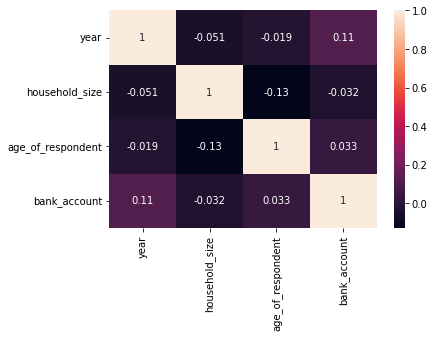

In [56]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

In [89]:
# #List os cat attributes for cramer v correlation
# cat_attributes_list = cat_attributes.columns.tolist()

# #dict to get all corr (rowxcolumn)
# corr_dict = {}
# for i in range(len(cat_attributes_list)):
#     corr_list=[]
#     for j in range(len(cat_attributes_list)):
#         ref = cat_attributes_list[i]
#         feat = cat_attributes_list[j]
        
#         corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
#         corr_list.append(corr)
#     corr_dict[ref] = corr_list

/tmp/ipykernel_29307/742806758.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))


In [ ]:
corr_df = pd.DataFrame(corr_dict)
corr_df = corr_df.set_index(corr_df.columns)

In [ ]:
sns.heatmap(corr_df, annot=True);

## Feature Engineering

In [57]:
df2 = df1.copy()

In [60]:
df2.sample().T

,3409
country,Kenya
year,2018
uniqueid,uniqueid_4051
location_type,Rural
cellphone_access,Yes
household_size,2
age_of_respondent,74
gender_of_respondent,Male
relationship_with_head,Head of Household
marital_status,Married/Living together


In [126]:
df2['rural_cellphone_access'] = df2.apply(lambda x: 1 if (x['location_type']=='Rural') & (x['cellphone_access']=='Yes') else 0, axis=1)
df2['urban_cellphone_access'] = df2.apply(lambda x: 1 if (x['location_type']=='Urban') & (x['cellphone_access']=='Yes') else 0, axis=1)

In [127]:
df2['relationship_with_head'].unique()

array(['Head of Household', 'Spouse', 'Child', 'Parent', 'Other relative',
       'Other non-relatives'], dtype=object)

In [128]:
df2[['uniqueid', 'uid']].groupby('uniqueid').count().reset_index().sort_values('uid', ascending=False).head()

,uniqueid,uid
2528,uniqueid_353,4
6272,uniqueid_790,4
6232,uniqueid_784,4
4656,uniqueid_570,4
4655,uniqueid_57,4


Cada uniqueid pode ter até 4 pessoas (uid) diferentes de países diferentes cadastradas.

### Split train e validation

In [182]:
X = df2.drop(['uid', 'uniqueid', 'bank_account'], axis=1)
y = df2['bank_account'].copy()

X_train, X_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2)

# Data preparation

In [183]:
df3 = pd.concat([X_train, y_train], axis=1)
df3

,country,year,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,rural_cellphone_access,urban_cellphone_access,bank_account
5505,Kenya,2018,Rural,Yes,4,20,Female,Spouse,Married/Living together,No formal education,Farming and Fishing,1,0,0
7378,Kenya,2018,Rural,Yes,6,29,Male,Head of Household,Married/Living together,Primary education,Farming and Fishing,1,0,0
7644,Rwanda,2016,Rural,Yes,6,45,Male,Head of Household,Married/Living together,Primary education,Informally employed,1,0,0
8393,Tanzania,2017,Urban,No,3,75,Male,Head of Household,Single/Never Married,No formal education,Remittance Dependent,0,0,0
10347,Kenya,2018,Rural,Yes,3,62,Female,Head of Household,Single/Never Married,Secondary education,Farming and Fishing,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307,Tanzania,2017,Rural,Yes,2,35,Male,Head of Household,Single/Never Married,Tertiary education,Self employed,1,0,0
10870,Uganda,2018,Rural,Yes,9,56,Male,Head of Household,Married/Living together,Primary education,Self employed,1,0,0
5584,Kenya,2018,Rural,Yes,5,36,Female,Spouse,Married/Living together,Primary education,Farming and Fishing,1,0,1
176,Tanzania,2017,Urban,No,4,85,Male,Head of Household,Single/Never Married,No formal education,Self employed,0,0,0


In [184]:
mms = pp.MinMaxScaler()

### Rescala

In [185]:
df3['year'] = mms.fit_transform(df3[['year']])
df3['household_size'] = mms.fit_transform(df3[['household_size']])
df3['age_of_respondent'] = mms.fit_transform(df3[['age_of_respondent']])


### Encoding 

In [186]:
df3 = pd.get_dummies(df3, prefix='gender', columns=['gender_of_respondent'])

df3 = pd.get_dummies(df3, prefix='location_type', columns=['location_type'])

In [189]:
#frequency, target, onehot, label


#location type (OHE) 

# df3 = pd.get_dummies(df3, prefix='location_type', columns=['location_type'])

#cellphone access (1,0)

df3['cellphone_access'] = df3['cellphone_access'].apply(lambda x: 1 if x=='Yes' else 0)

#gender (OHE)

# df3 = pd.get_dummies(df3, prefix='gender', columns=['gender_of_respondent'])


#country  -- 

target_encode_country = df3.groupby('country')['bank_account'].mean()
df3.loc[:,'country'] = df3['country'].map(target_encode_country)


#relationship_with_head

target_encode_relationship_with_head = df3.groupby('relationship_with_head')['bank_account'].mean()
df3.loc[:,'relationship_with_head'] = df3['relationship_with_head'].map(target_encode_relationship_with_head)


#marital_status

target_encode_marital_status = df3.groupby('marital_status')['bank_account'].mean()
df3.loc[:,'marital_status'] = df3['marital_status'].map(target_encode_marital_status)


#education_level

target_encode_education_level = df3.groupby('education_level')['bank_account'].mean()
df3.loc[:,'education_level'] = df3['education_level'].map(target_encode_education_level)

#job_type

target_encode_job_type = df3.groupby('job_type')['bank_account'].mean()
df3.loc[:,'job_type'] = df3['job_type'].map(target_encode_job_type)

,country,year,cellphone_access,household_size,age_of_respondent,relationship_with_head,marital_status,education_level,job_type,rural_cellphone_access,urban_cellphone_access,bank_account,gender_Female,gender_Male,location_type_Rural,location_type_Urban
5505,0.262058,1.0,1,0.15,0.047619,0.112206,0.176999,0.040782,0.123902,1,0,0,1,0,1,0
7378,0.262058,1.0,1,0.25,0.154762,0.179684,0.176999,0.087312,0.123902,1,0,0,0,1,1,0
7644,0.116340,0.0,1,0.25,0.345238,0.179684,0.176999,0.087312,0.073909,1,0,0,0,1,1,0
8393,0.083650,0.5,0,0.10,0.702381,0.179684,0.113579,0.040782,0.090000,0,0,0,0,1,0,1
10347,0.262058,1.0,1,0.10,0.547619,0.179684,0.113579,0.244207,0.123902,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307,0.083650,0.5,1,0.05,0.226190,0.179684,0.113579,0.476496,0.134009,1,0,0,0,1,1,0
10870,0.077011,1.0,1,0.40,0.476190,0.179684,0.176999,0.087312,0.134009,1,0,0,0,1,1,0
5584,0.262058,1.0,1,0.20,0.238095,0.112206,0.176999,0.087312,0.123902,1,0,1,1,0,1,0
176,0.083650,0.5,0,0.15,0.821429,0.179684,0.113579,0.040782,0.134009,0,0,0,0,1,0,1


In [192]:
X = df3.drop(['bank_account'], axis=1)
y = df3['bank_account'].copy()

X_train, X_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2)

# Modelo de ML

## Random Forest Classifier

In [204]:
#model definition
rf_model = en.RandomForestClassifier()

#model training
rf_model.fit(X_train, y_train)

#model predict
yhat_rf = rf_model.predict(X_val)

#metricas
metrics.f1_score(y_val, yhat_rf)

0.4670912951167728

In [206]:
metrics.accuracy_score(y_val, yhat_rf)

0.8666312433581297

In [207]:
metrics.balanced_accuracy_score(y_val, yhat_rf)

0.672387732379635

In [216]:
metrics.recall_score(y_val, yhat_rf)

0.3971119133574007

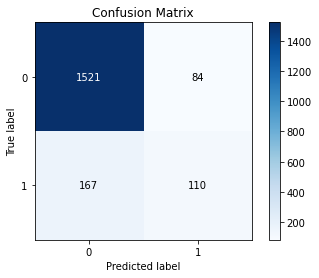

In [215]:
skplt.metrics.plot_confusion_matrix(y_val, yhat_rf);

In [ ]:
#melhorar feature engineering

#eda - Univariada sweetviz

#balanceamento

#feature selection - boruta, extra trees, rankd